<a href="https://colab.research.google.com/github/abdu18/Clean-Energy-Stock-Price-Prediction/blob/master/Clean_Energy_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices ()

In [0]:
import numpy as np
import datetime
from math import ceil
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [32]:
#Loading Yahoo Finance dataset
start = datetime.datetime(2010,9,7)
end = datetime.datetime(2019, 9, 7)

#Clean Energy Fuels Corp. (CLNE)
df = web.DataReader("CLNE", "yahoo", start, end)
df.tail(10)



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-23,2.03,1.94,2.00,1.94,1093400,1.94
2019-08-26,1.97,1.93,1.94,1.96,492900,1.96
2019-08-27,2.00,1.92,1.99,1.95,695900,1.95
2019-08-28,2.01,1.91,1.94,1.95,731100,1.95
2019-08-29,2.01,1.94,1.99,1.98,531300,1.98
2019-08-30,2.01,1.94,2.00,1.99,870200,1.99
2019-09-03,2.00,1.93,1.99,1.97,505100,1.97
2019-09-04,2.00,1.96,2.00,2.00,417300,2.00
2019-09-05,2.07,2.01,2.03,2.03,583000,2.03


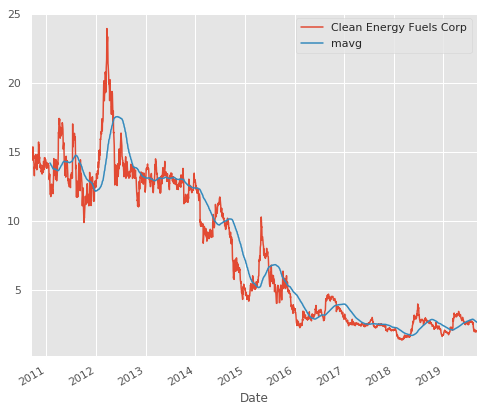

In [33]:
#Find the rolling mean of the stock
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

from matplotlib import style

#adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='Clean Energy Fuels Corp')
mavg.plot(label='mavg')
plt.legend()

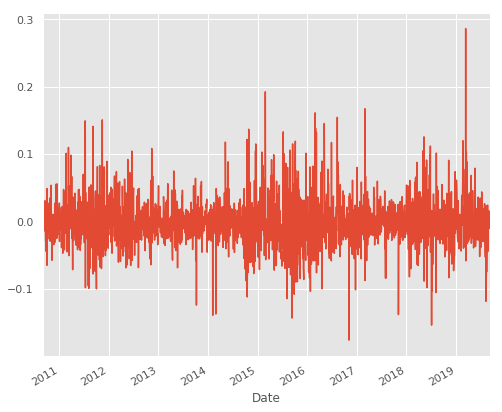

In [34]:
#plot the returns of the stock
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [0]:
#Analyzing competitor stocks: 

#Clean Coal Technologies, Inc.       (CCTC)
#Renewable Energy Group, Inc.        (REGI)
#SolarEdge Technologies, Inc.        (SEDG)
#First Trust Global Wind Energy ETF  (FAN)

dfcomp = web.DataReader(['CCTC', 'REGI', 'SEDG', 'FAN'], 'yahoo', start=start, end=end)['Adj Close']

Text(0, 0.5, 'Returns REGI')

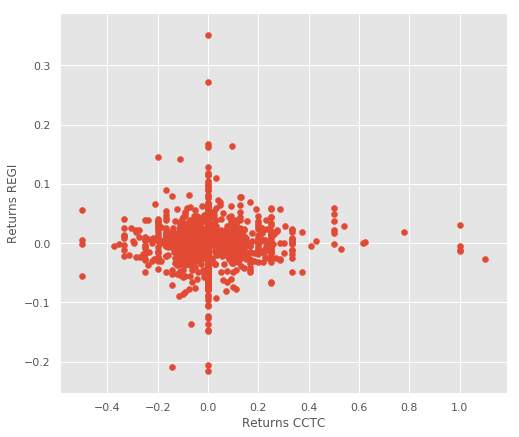

In [37]:
# run a correlation function to see if any of the stocks are correlated
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

#plotting competitors to see their return distributions
plt.scatter(retscomp.CCTC, retscomp.REGI)
plt.xlabel('Returns CCTC')
plt.ylabel('Returns REGI')

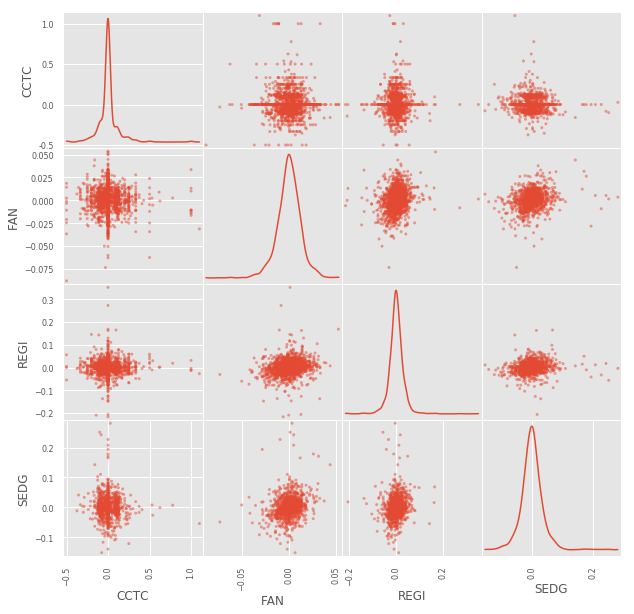

In [38]:
#using Kernel Density Estimate to smooth data and visualize possible correlations
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

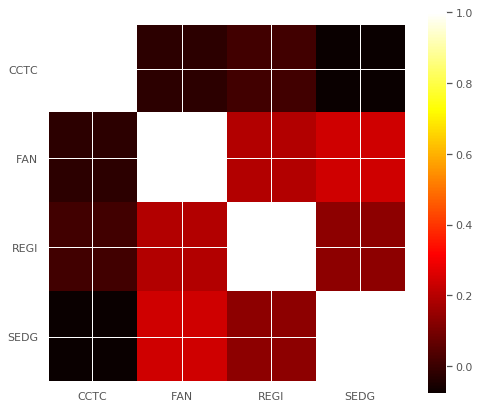

In [39]:
#Heatmap to prove the positive correlations
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

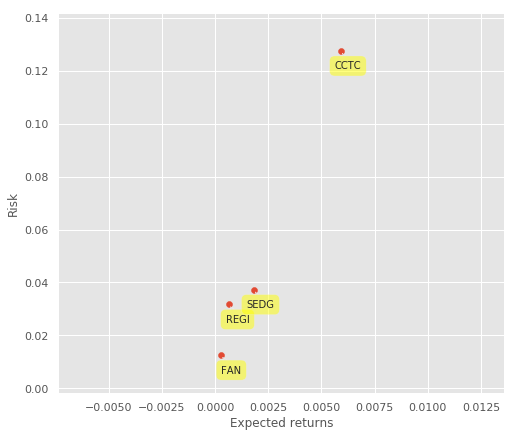

In [40]:
#risk and return comparisons for the competing Energy stocks
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

# *Predicting Stocks Price*
# Clean Energy Fuels Corp. (CLNE) 


In [0]:
#Engineering some features for the algorithms: High Low Percentage and Percentage Change
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0


In [0]:
##PREPROCESSING AND DATA VALIDATION
#Drop missing value
dfreg.fillna(value=-99999, inplace = True)
dfreg.dropna(inplace=True) #CORRECTION: ADDED NEW SO X AND y ARE EQUAL

#we want to separate 1% of the data to forecast
forecast_out = int(ceil(.01 * len(dfreg))) #CORRECTION: was called incorrectly in former code below
#FORMERCODE forecast_out = int(math.ceil(0.01 * len(dfreg)))

In [0]:
#separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [0]:
#Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

#Finally we want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

#Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

#CLASSIFIERS!

#DEFINING X_train before we use it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# **Model Generation**

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

#Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

#Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

#KNN regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

#Evaluate all of the models against eachother
confidencereg = clfreg.score(X_test,y_test)
confidencepoly2 = clfpoly2.score(X_test, y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
('The linear regression confidence is', confidencereg)
('The quadratic regression 2 confidence is ', confidencepoly2)
('The quadratic regression 3 confidence is ', confidencepoly3)
('The knn regression confidence is ', confidenceknn)

#printing some of the stocks forecasts
forecast_set_reg = clfreg.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_poly2 = clfpoly2.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_poly3 = clfpoly3.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
forecast_set_knn = clfknn.predict(X_lately) #CORRECTION: NEWLY CHANGED NAMES
dfreg['Forecast'] = np.nan


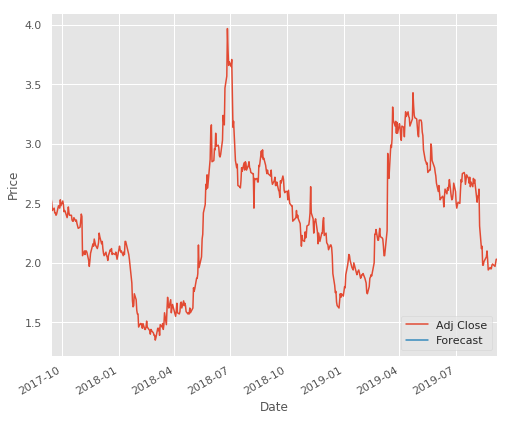

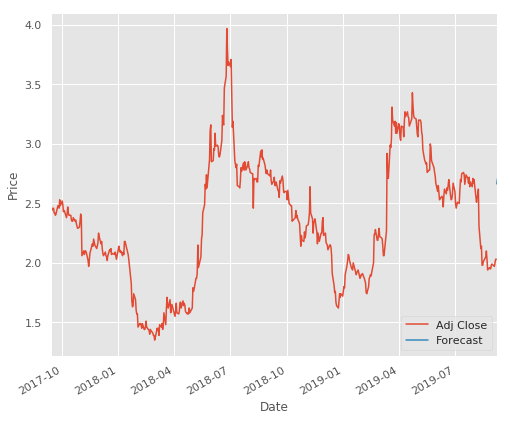

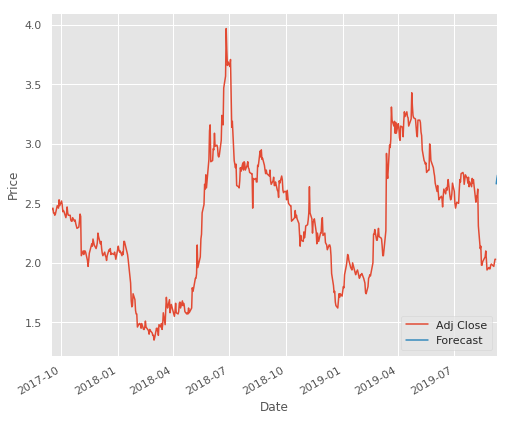

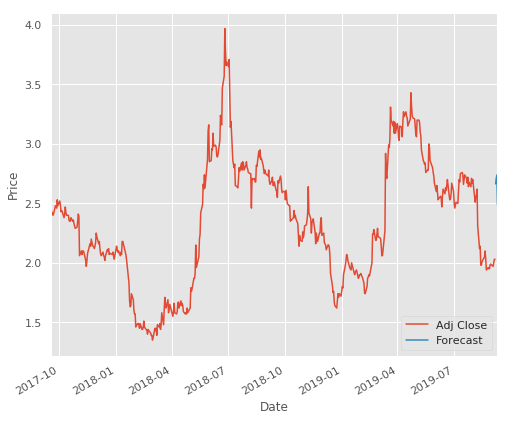

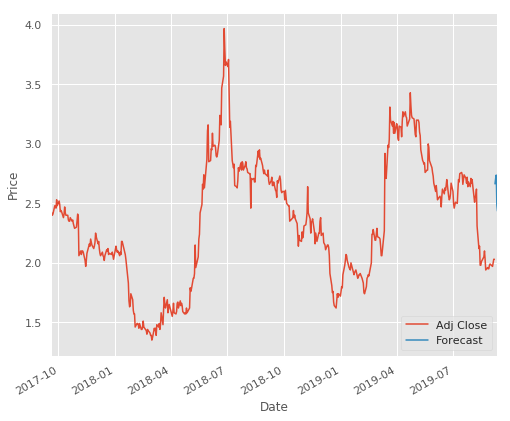

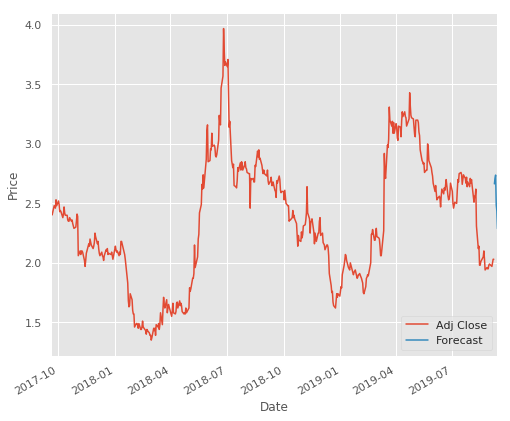

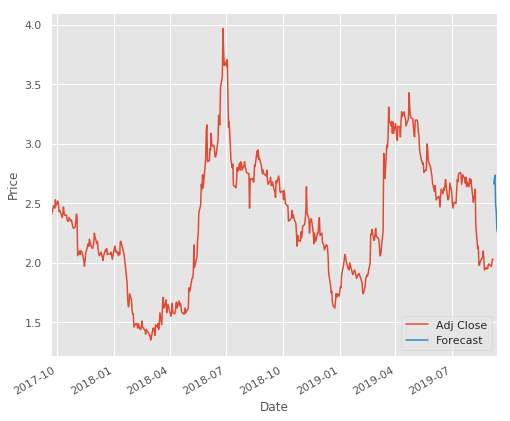

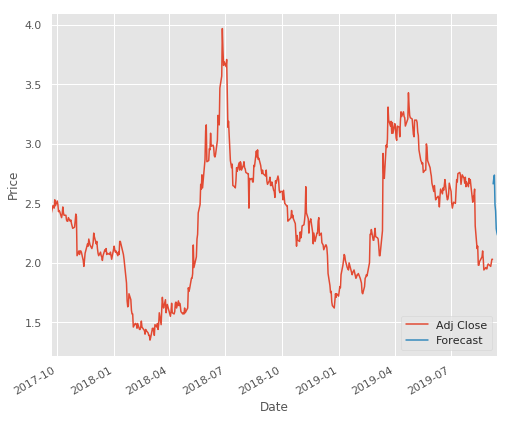

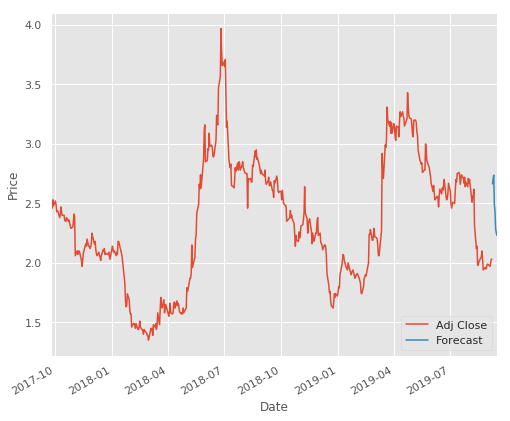

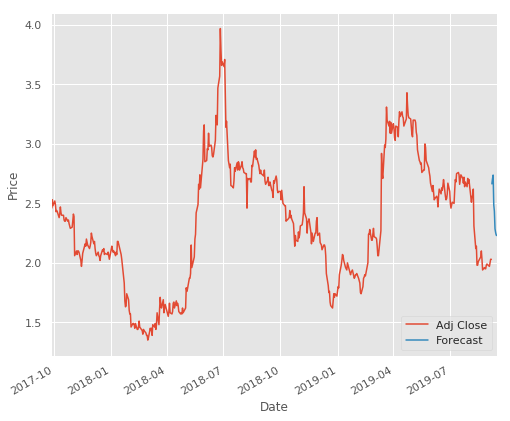

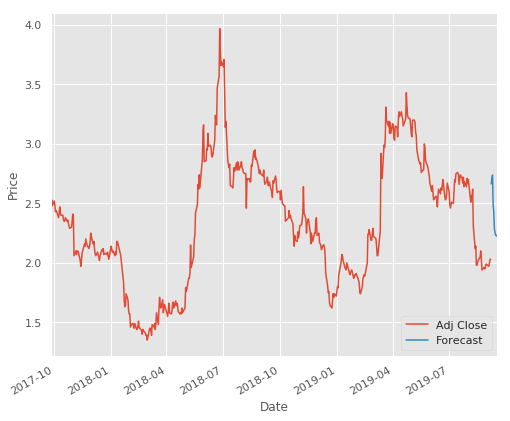

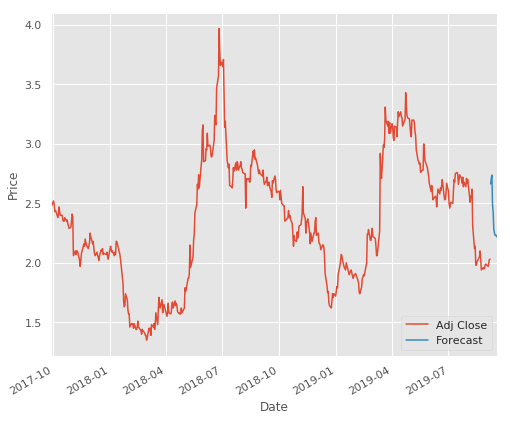

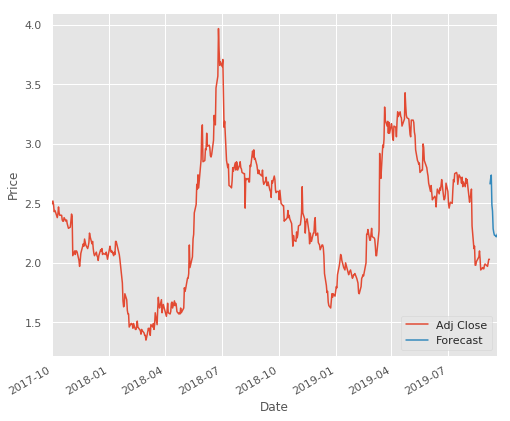

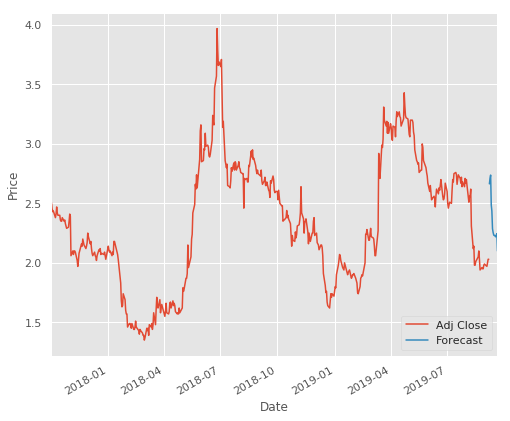

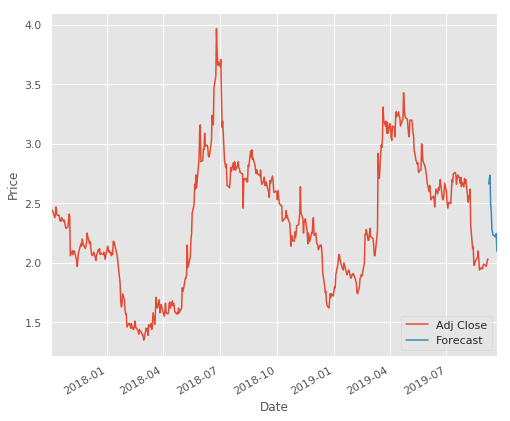

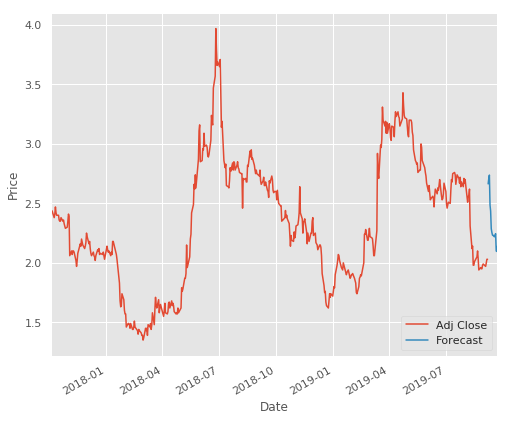

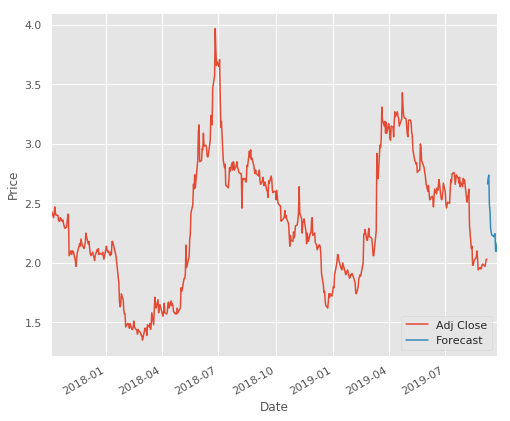

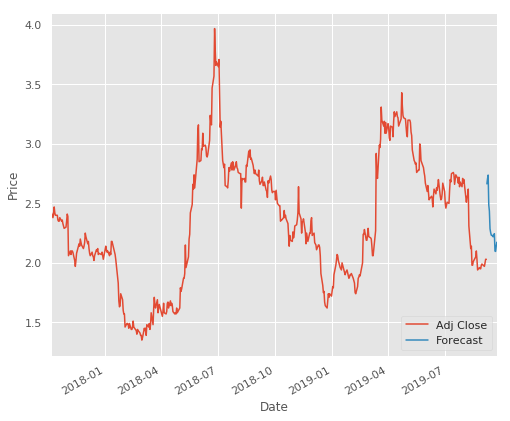

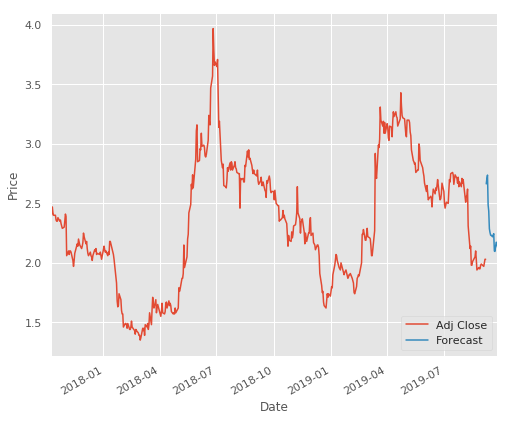

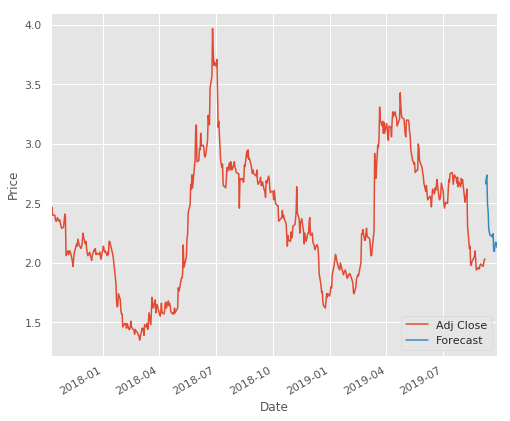

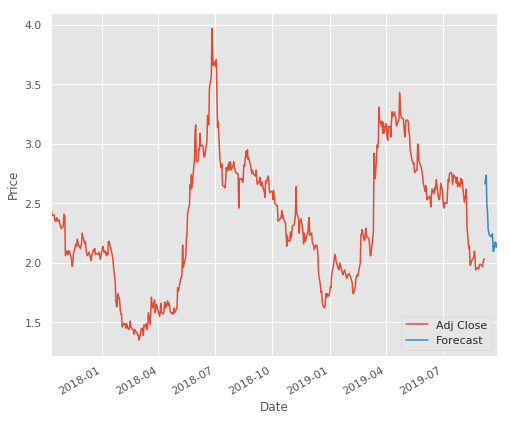

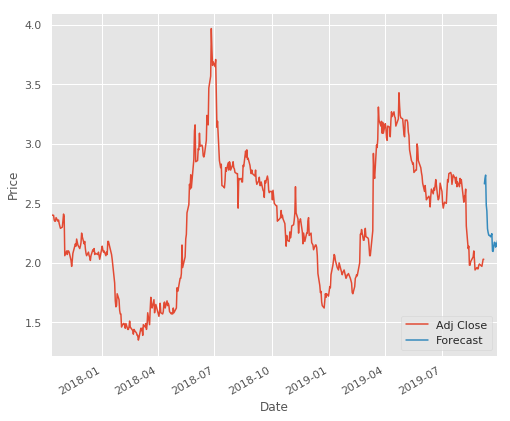

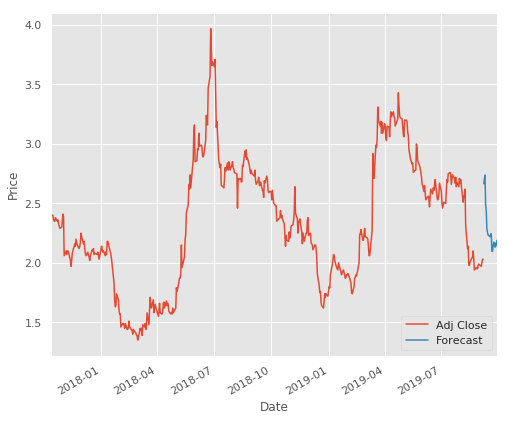

In [66]:
#results

#Plotting the forecast with existing historical data so we can compare it to future price movements
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set_reg: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

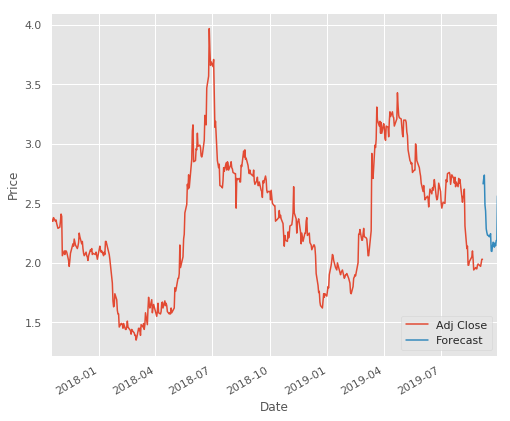

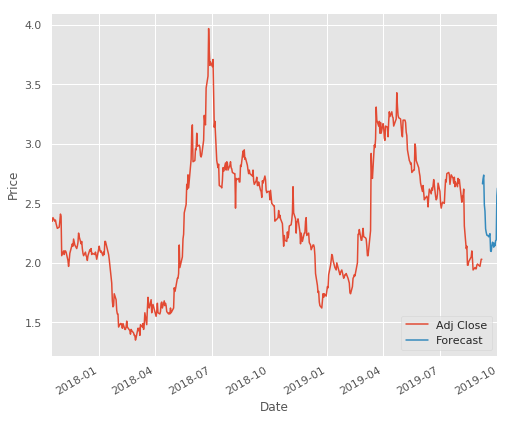

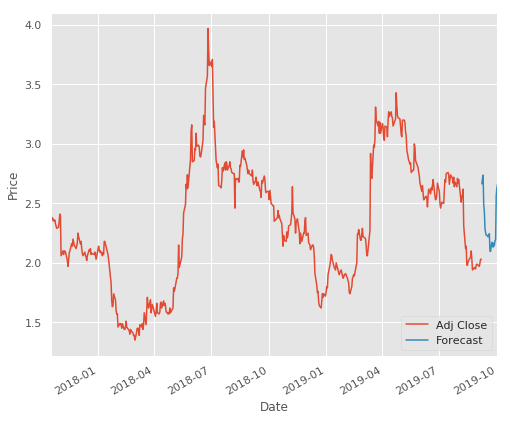

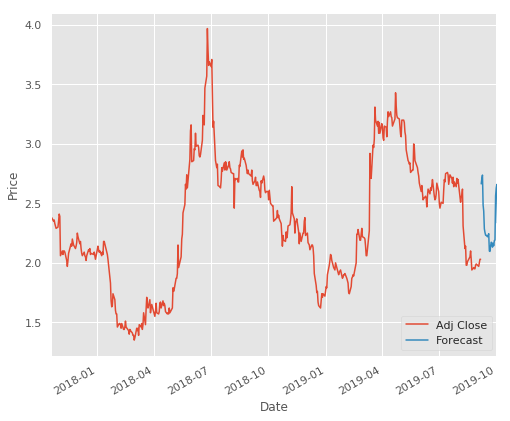

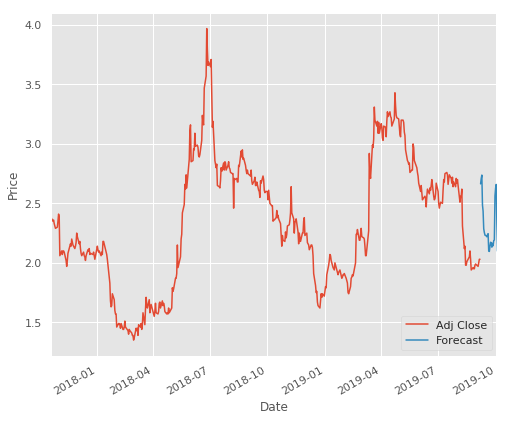

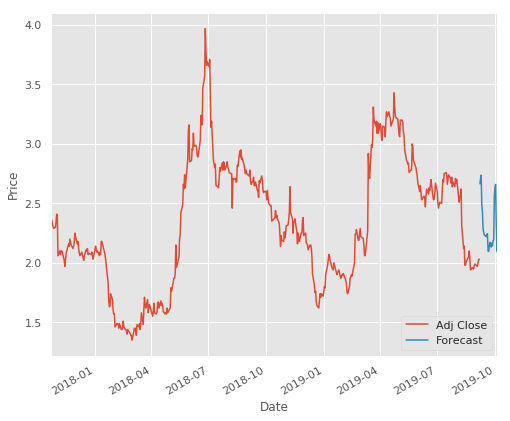

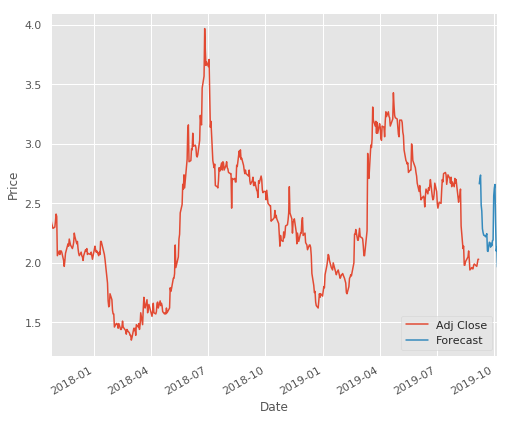

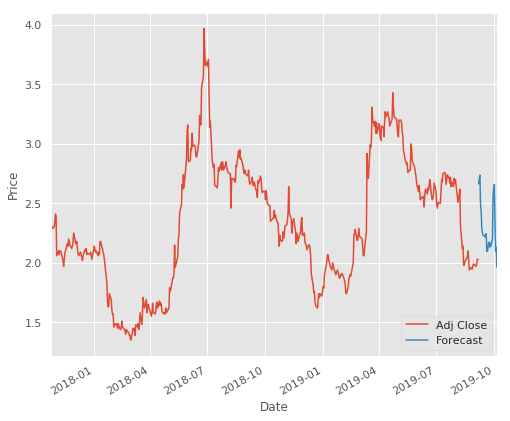

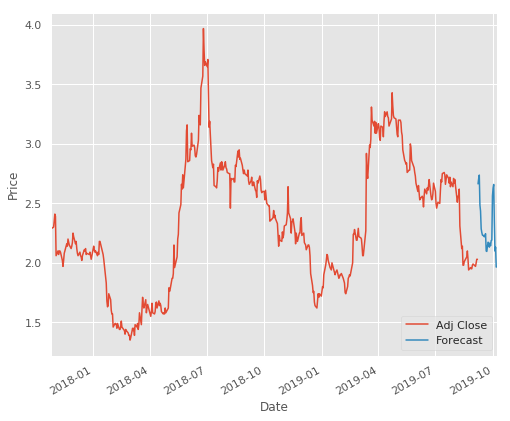

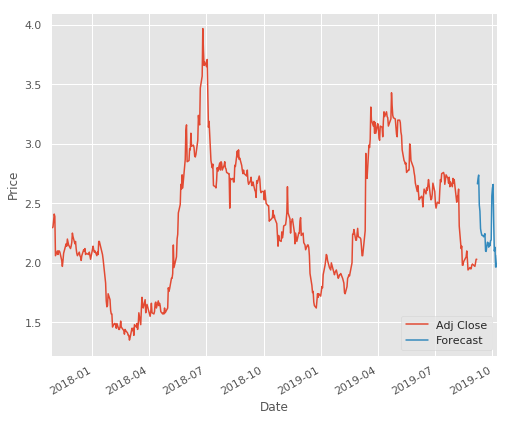

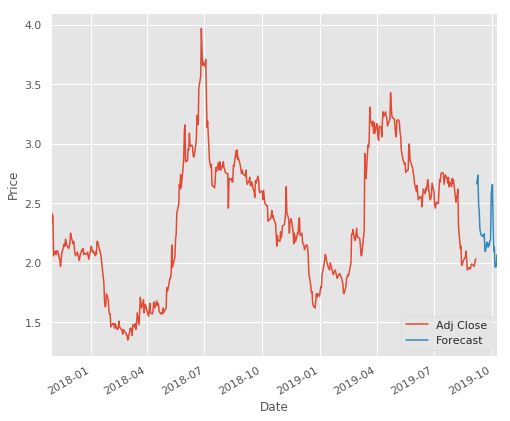

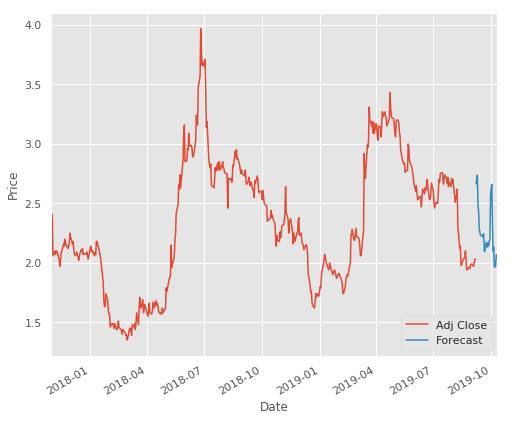

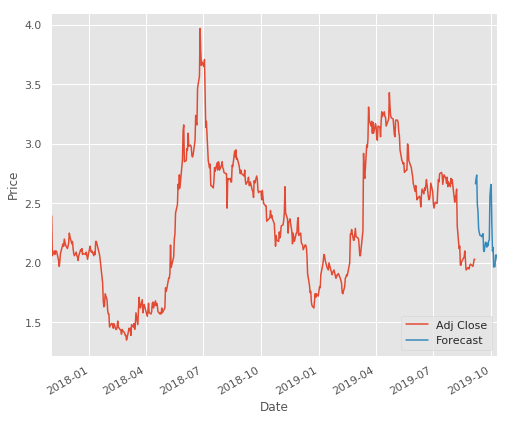

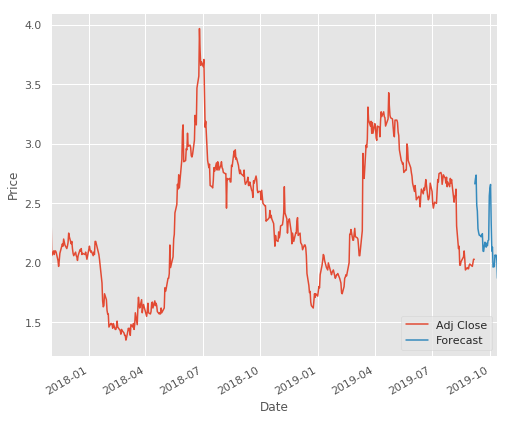

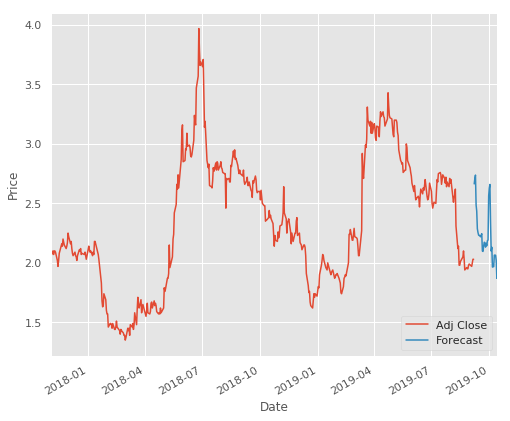

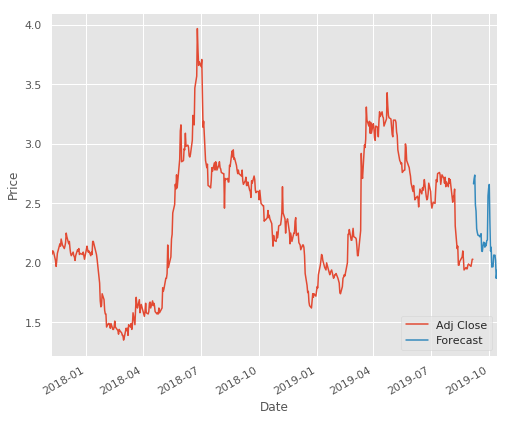

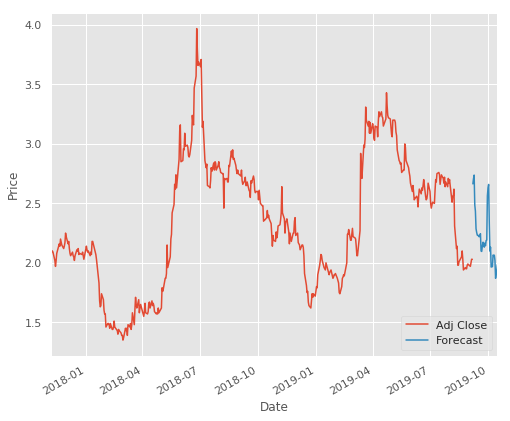

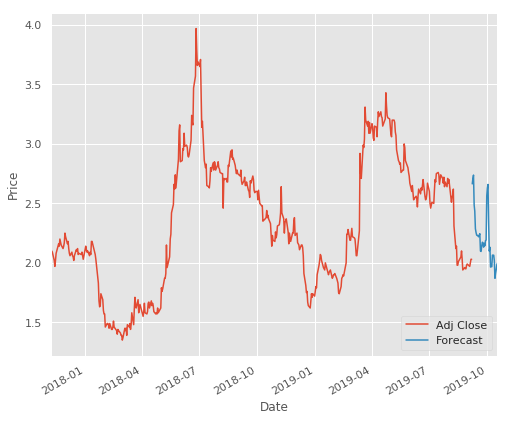

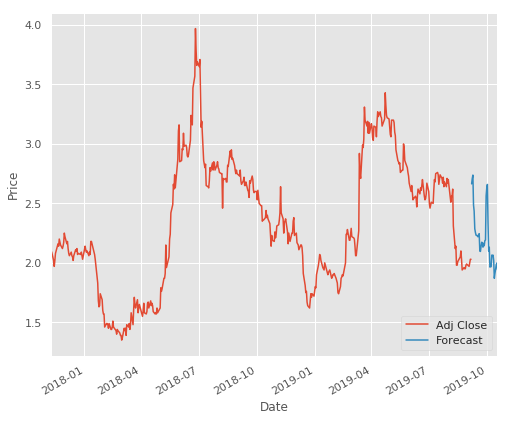

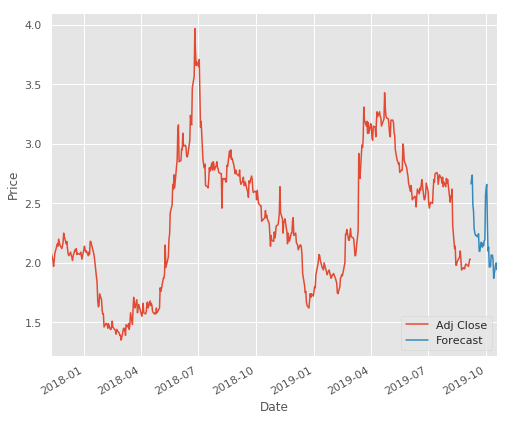

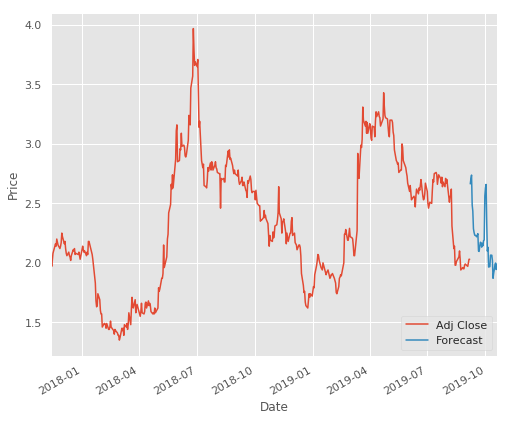

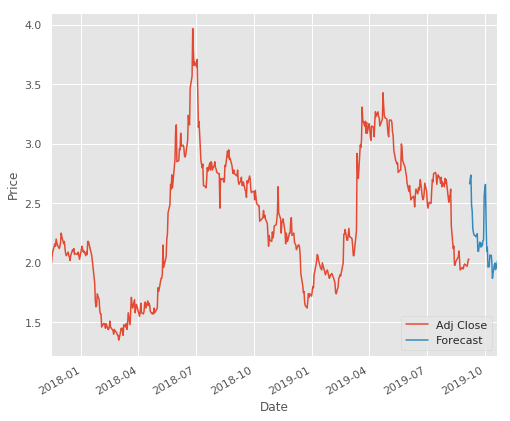

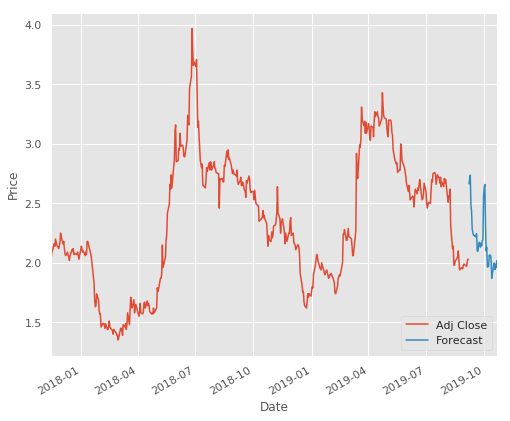

In [67]:
for i in forecast_set_poly2: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

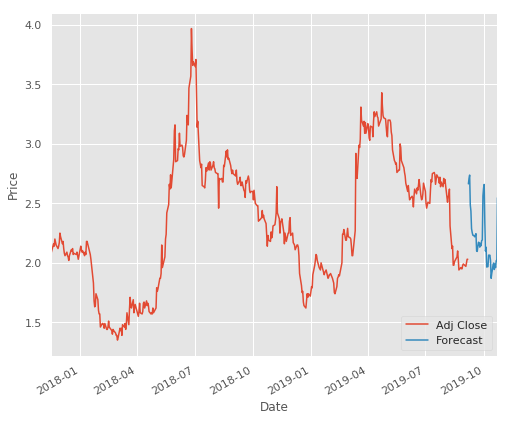

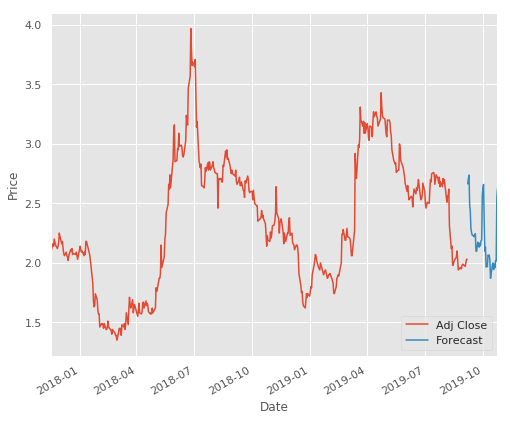

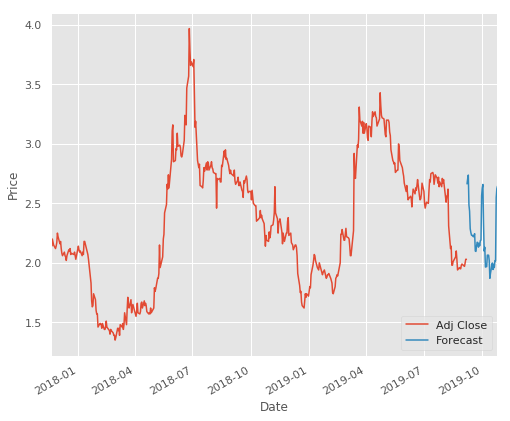

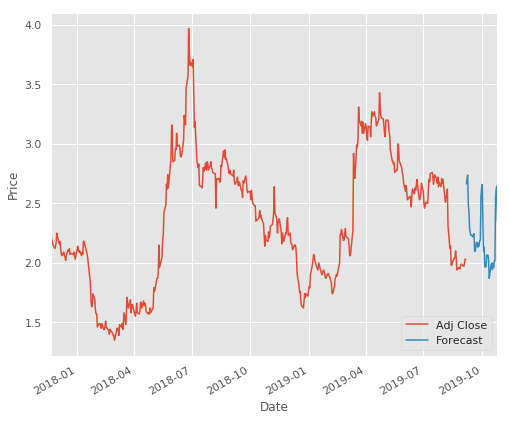

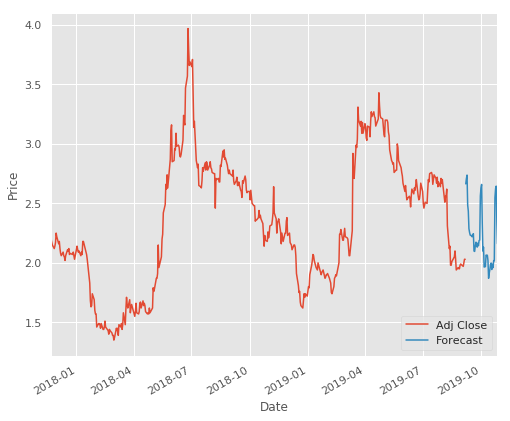

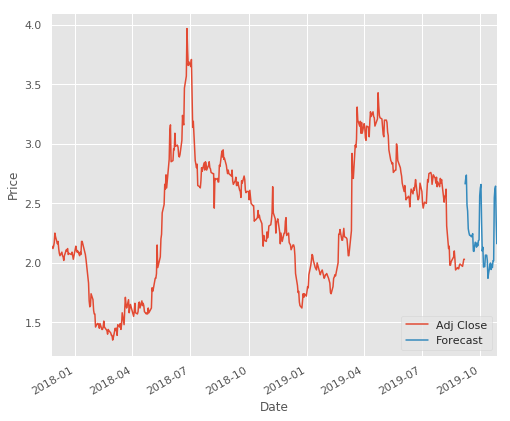

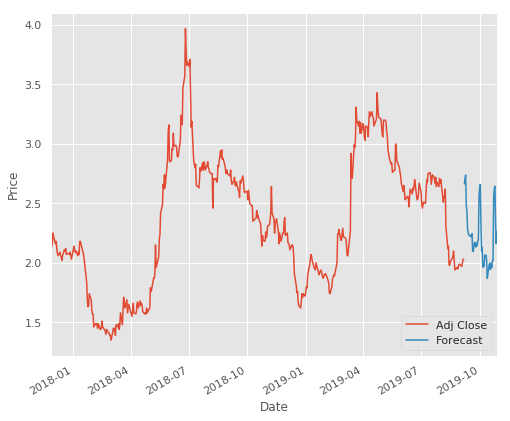

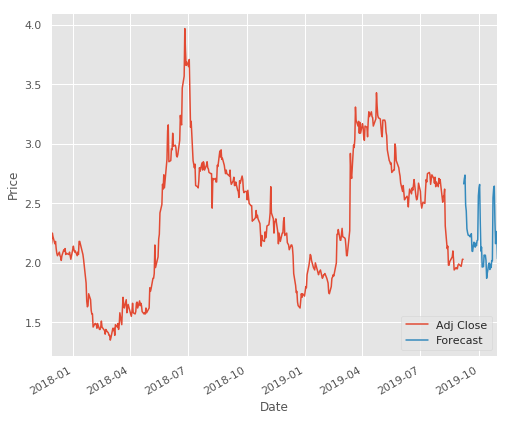

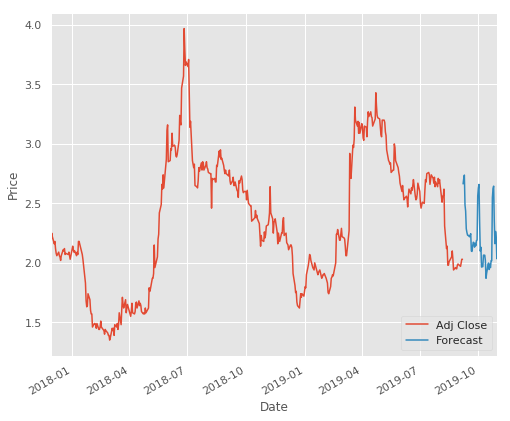

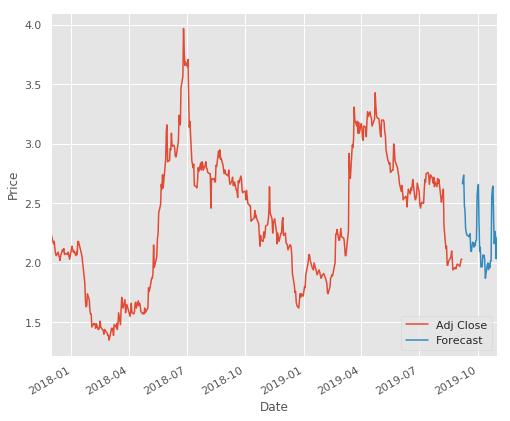

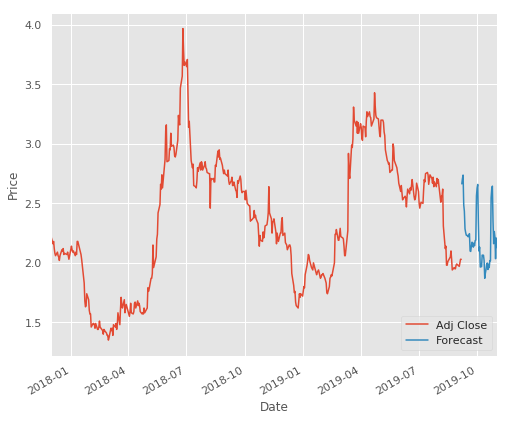

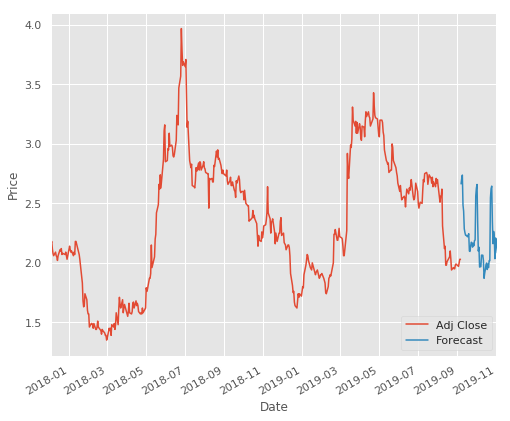

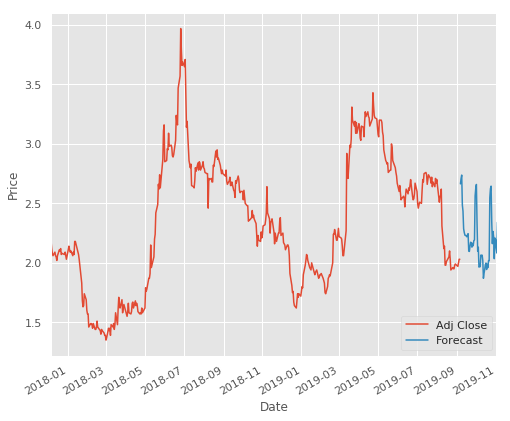

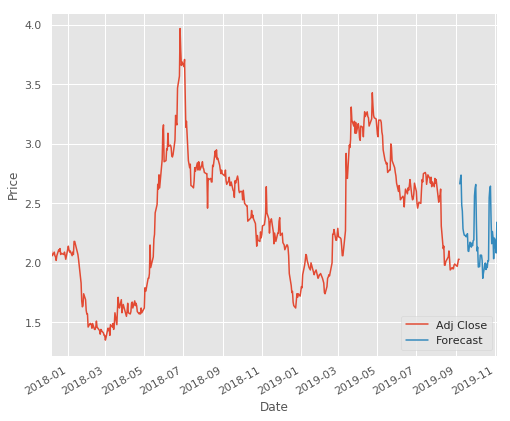

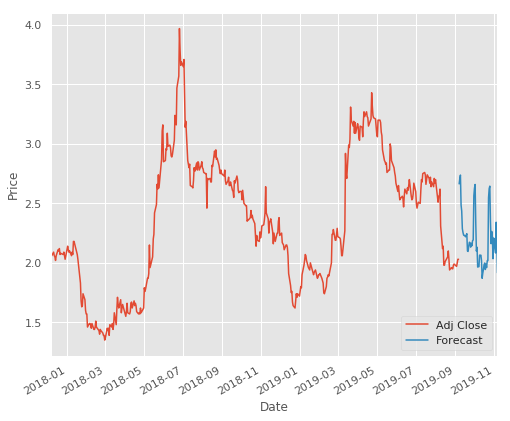

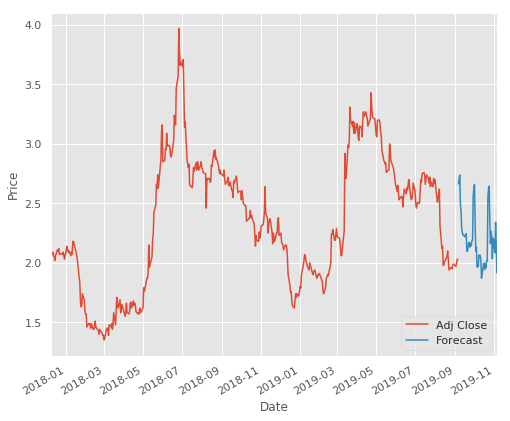

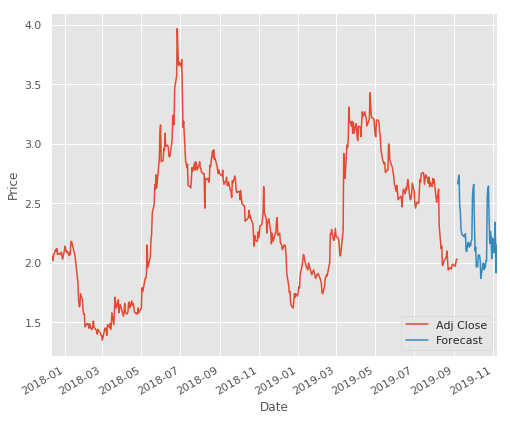

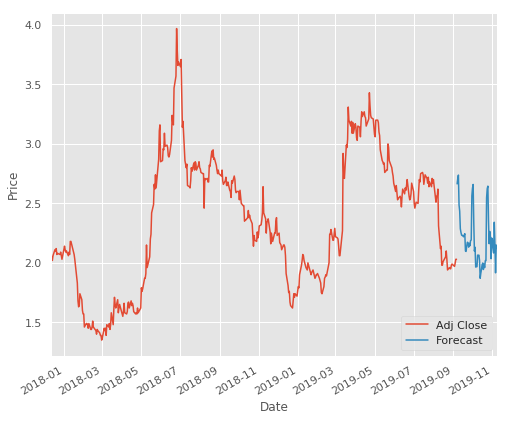

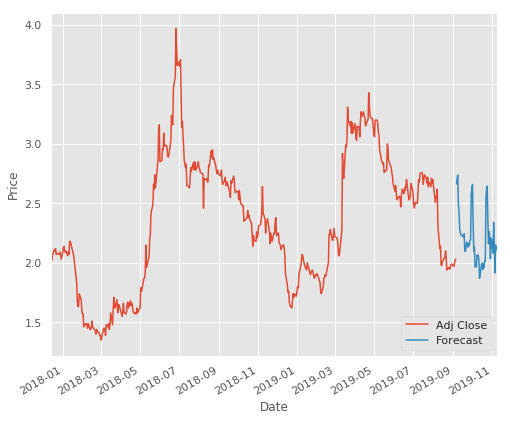

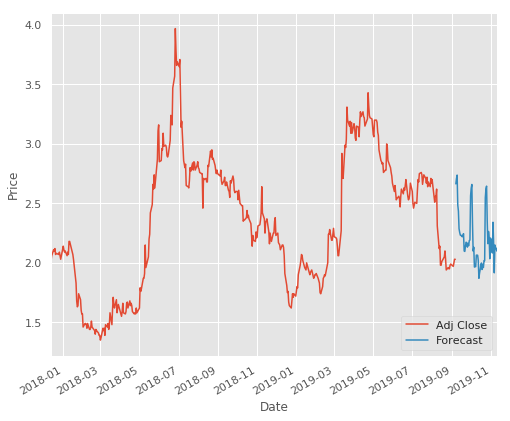

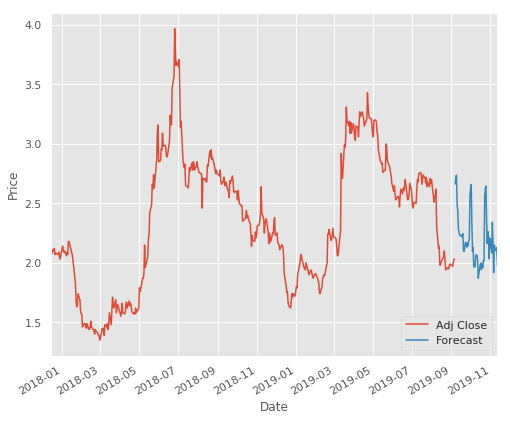

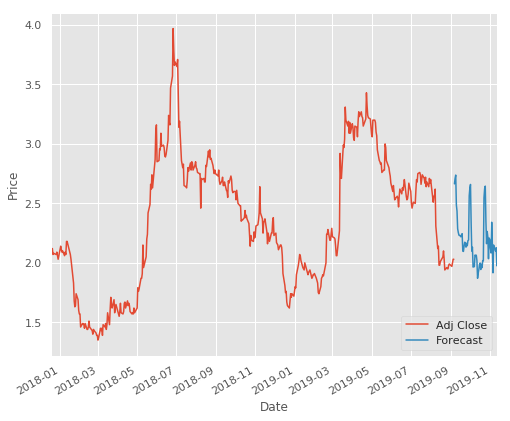

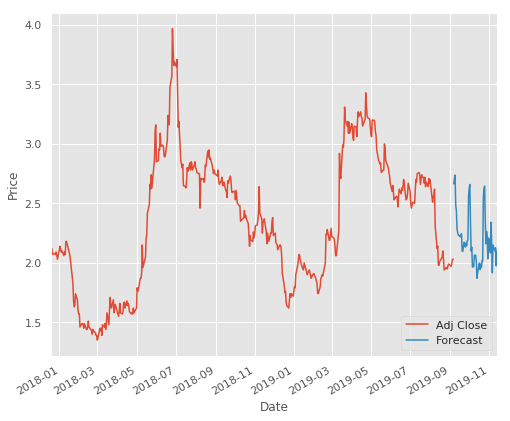

In [68]:
for i in forecast_set_poly3: #CORRECTION: NAME UPDATED AND CODE DUPLICATED FOR NEW ALGORITHM
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    dfreg['Adj Close'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()